In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline  


In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import cmocean
import xskillscore as xss

# load pre-built data classes
from steric_height import StericHeight
from plotting_fns import PlottingFns as pfns
from utils import Utils as utls, Color as uc
from region import Region as rg
from data_handler import *
import xesmf as xe



pfns = pfns()

In [3]:
dot_ds = DOT().ds
lwe_ds = GRACE().ds
msl_ds = ERA5().ds

sha = StericHeight(ssh_ref='DOT',
                   ssh=dot_ds.dot,
                   lwe=lwe_ds.lwe_thickness,
                   msl=msl_ds.msl
                  ).get_sha()


gpha = GPHA()

In [4]:
sta = dot_ds.time[0]
fin = dot_ds.time[-1]

In [5]:
sta.to_pandas()

numpy.datetime64('2002-07-01T00:00:00.000000000')

In [6]:
# get hi res GEBCO
gebco_coarse = GEBCO(coarsen_factor=40).ds
gebco_fine = GEBCO(coarsen_factor=10).ds

In [7]:
profiles = gpha.profile_df
profiles_argo = profiles[profiles.float_type=='ARGO']
profiles_meop = profiles[profiles.float_type=='MEOP']
profiles_gridded = gpha.gridded_ds

In [8]:
profiles_monthly = profiles[(profiles.index >= sta.to_pandas()) & (profiles.index <= fin.to_pandas())].groupby(pd.Grouper(freq='MS'))
profiles_sum = profiles_monthly.count().gph.sum()

In [9]:
profiles_gridded.profile_cnt.sum()

<xarray.DataArray 'profile_cnt' ()> Size: 8B
array(289441.)

In [19]:
monthly_sum = profiles_gridded.profile_cnt.groupby('time.month').sum()
yearly_sum = profiles_gridded.profile_cnt.groupby('time.year').sum()

In [36]:
yearly_sum.year

<xarray.DataArray 'year' (year: 23)> Size: 184B
array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
Coordinates:
  * year     (year) int64 184B 2001 2002 2003 2004 2005 ... 2020 2021 2022 2023

Text(0.0, 1.0, '(c)')

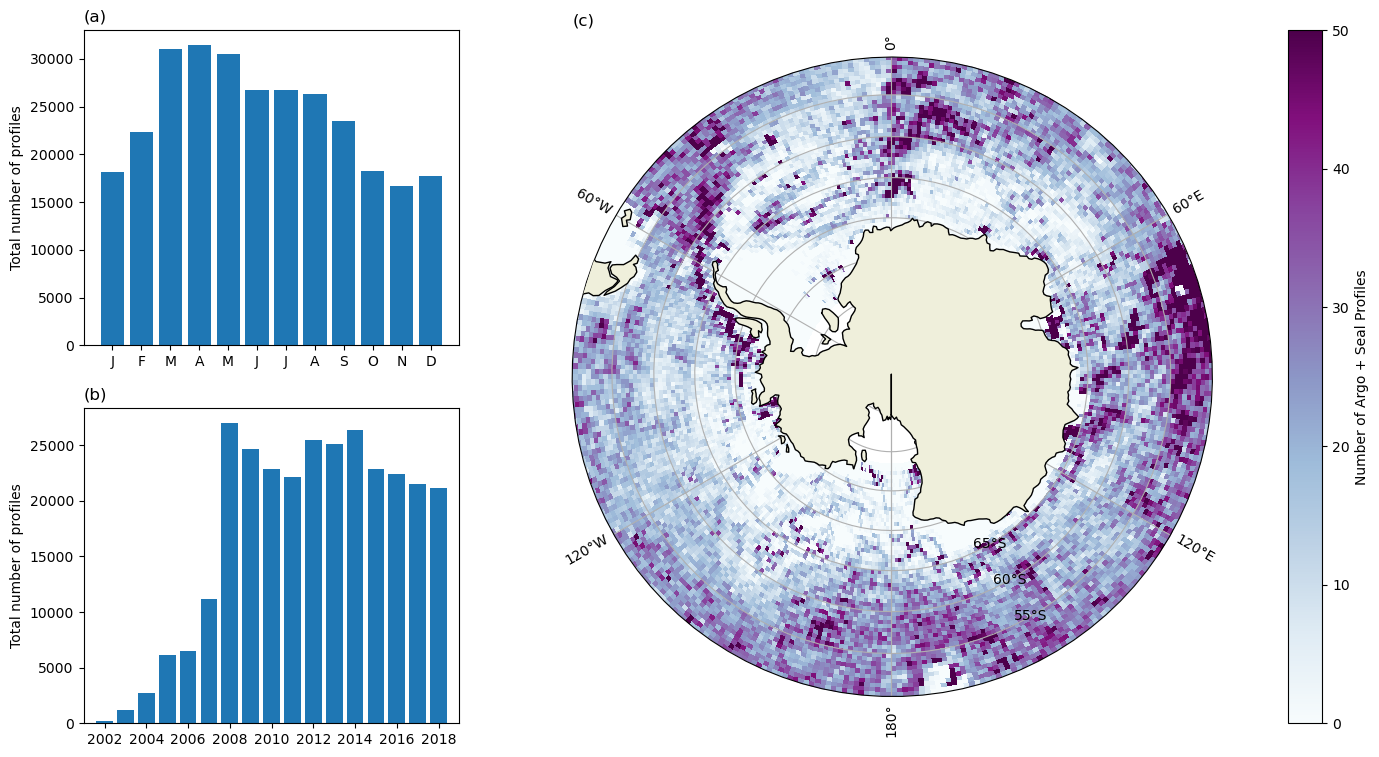

In [40]:
fig = plt.figure(figsize=(16,9))
axs=[]

gs = fig.add_gridspec(2,2,width_ratios=[1,2])

# sha, gpha and sic climatology
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[1, 0]))

axs[0].bar(monthly_sum.month,monthly_sum.sum(['latitude','longitude']))
axs[0].set_xticks(np.arange(1,13))
axs[0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0].ax.set_xlim([0.5,12.5])
axs[0].set_ylabel('Total number of profiles')
axs[0].set_title('(a)',loc='left')


axs[1].bar(yearly_sum.year,yearly_sum.sum(['latitude','longitude']))
axs[1].set_xlim([2001,2019])
axs[1].set_ylabel('Total number of profiles')
axs[1].set_title('(b)',loc='left')


axs.append(fig.add_subplot(gs[0:2, 1],projection=ccrs.SouthPolarStereo()))

pfns.sp(axs[2],profiles_gridded.profile_cnt.sum(('time')),vmin=0,vmax=50,cbar="Number of Argo + Seal Profiles",cmap='BuPu',cbar_orientation='vertical')
axs[2].set_title('(c)',loc='left')


In [7]:
sha_gph_ = xr.merge([sha,profiles_gridded])

In [8]:
sha_gph_['profile_gpha'] = 100*(sha_gph_.profile_gph - sha_gph_.profile_gph.sel(time=slice(sta,fin)).mean('time'))

In [10]:
# starting resolution 0.5 degrees lat (56km); 1 degree longitude (~47km)
# coarsen by 6x so it's roughly 300km
coarsen_by=6
n_cutoff=6*coarsen_by
sha_gph = sha_gph_.coarsen(latitude=coarsen_by, longitude=coarsen_by, boundary='trim').mean()

In [11]:
n_months_with_gph = (~np.isnan(sha_gph.profile_gpha)).sum('time')
sha_corr = sha_gph.sha.where(n_months_with_gph > n_cutoff, drop = True)
gph_corr = sha_gph.profile_gpha.where(n_months_with_gph > n_cutoff, drop = True)

In [12]:
sice = xr.open_dataset('../Research/data/PROCESSED/nsidc_sea_ice.nc').nsidc_nt_seaice_conc_monthly
regridder = xe.Regridder(sice,sha_gph_.sha.mean('time'),'bilinear')
sice = regridder(sice)
siz = sice.where(sice > 0.15)

sic_cmt = sice.groupby('time.month').mean()
siz_cmt = siz.groupby('time.month').mean()

in_siz = sic_cmt.sel(month=8) > 0.15
in_piz = sice.quantile(0.05,dim='time')>0.15#(sice > 0.15).all(dim='time')
in_miz = in_siz & ~in_piz

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [13]:
sha_gph_['sice']=sice

In [14]:
def cmt_compare(ds,ax1,ax2,ax3):
    
    data_monthly = ds.where(~np.isnan(ds.sha))
    data_monthly_mean = data_monthly.mean(['latitude','longitude'])
    
    # climatology
    cmt = data_monthly.groupby('time.month').mean('time',skipna=True)
    cmt_mean = cmt.mean(['latitude','longitude'])

    def plot_climatology(ax,var,cl,c,ttl,mkr='-'):
        for grp in data_monthly_mean.groupby('time.year'):
            data = grp[1].groupby('time.month').mean()
            ax.plot(data.month,data[var],mkr,label=grp[0],c=cl)
        ax.plot(cmt.month,cmt_mean[var].to_numpy(),'-',c=c)
        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
        ax.set_xlim([0.5,12.5])
        if var == 'sice':
            ax.set_ylim([0,0.5])
        else:
            ax.set_ylim([-3,3])
        ax.set_ylabel(ttl)
        #ax.set_title(ttl,loc='left')
        ax.grid()

    plot_climatology(ax1,'sha',uc.SHA.value[1],uc.SHA.value[0],'SHA (cm)')
    plot_climatology(ax2,'profile_gpha',uc.GPHA.value[1],uc.GPHA.value[0],'GPHA (cm)')
    plot_climatology(ax3,'sice',uc.SICE.value[1],uc.SICE.value[0],'SIC (frac)')


    
    

MINLAT -50 AND MAXLAT -50 TOO CLOSE TOGETHER - CHANGING MAXLAT TO <xarray.DataArray 'latitude' ()> Size: 8B
array(-53.25)
Coordinates:
    latitude  float64 8B -53.5


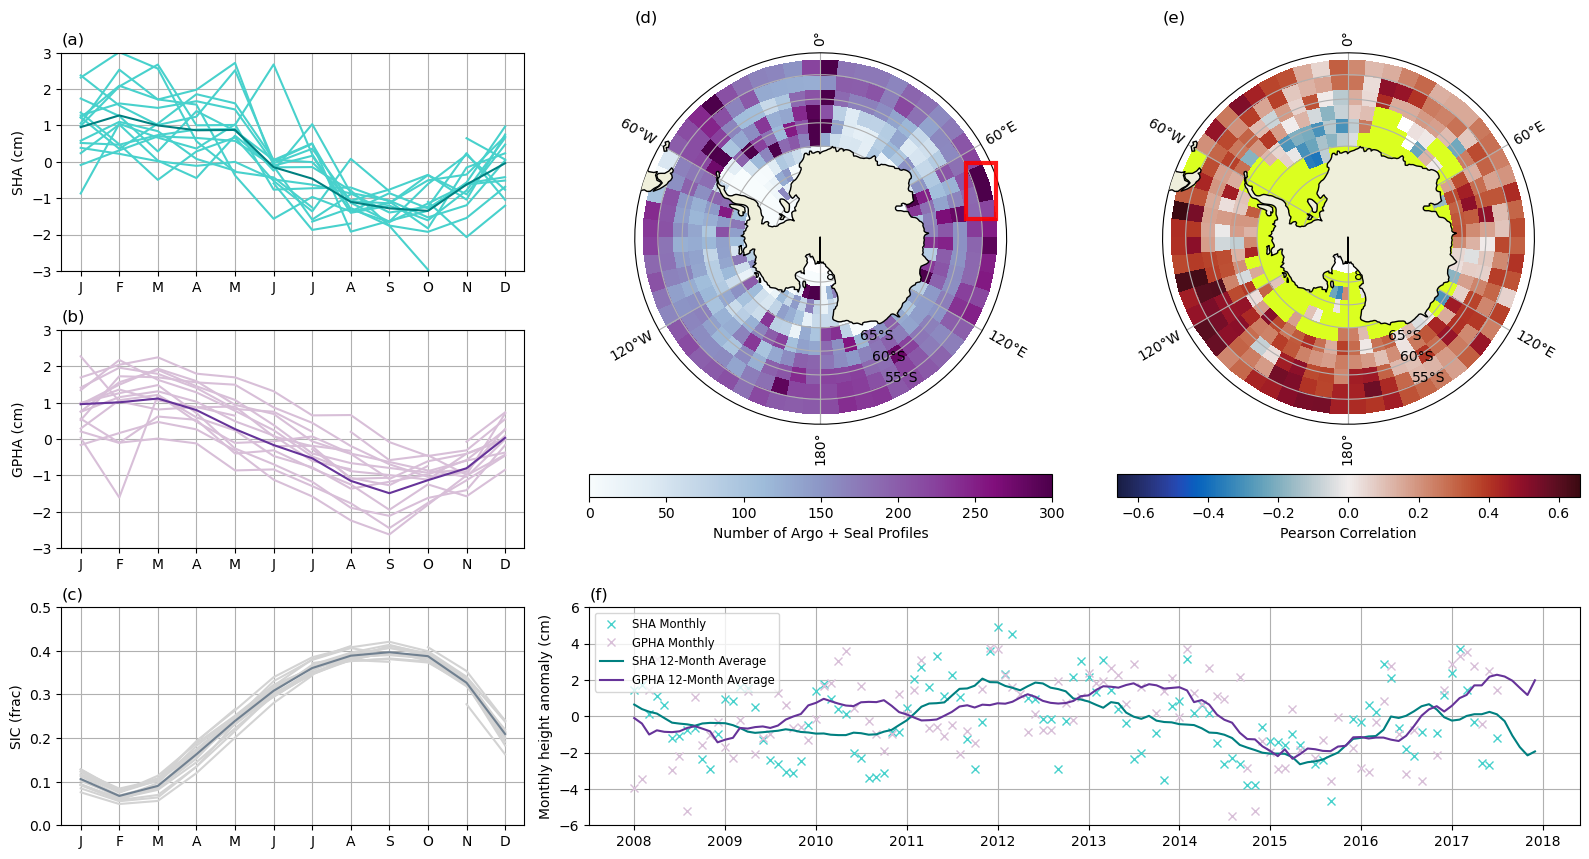

In [23]:

fig = plt.figure(figsize=(16,14))
axs=[]

gs = fig.add_gridspec(5,3)

# sha, gpha and sic climatology
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[2, 0]))

cmt_compare(sha_gph_,axs[0],axs[1],axs[2])
axs[0].set_title('(a)',loc='left')
axs[1].set_title('(b)',loc='left')
axs[2].set_title('(c)',loc='left')

# density and correlation
axs.append(fig.add_subplot(gs[0:2, 1],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[0:2, 2],projection=ccrs.SouthPolarStereo()))

pfns.sp(axs[3],sha_gph.profile_cnt.sum(('time')),vmin=0,vmax=300,cbar="Number of Argo + Seal Profiles",cmap='BuPu',cbar_orientation='horizontal')
axs[3].set_title('(d)',loc='left')

# create a mask to hide places with less than 6 profiles
mask6_ = xr.ones_like(n_months_with_gph)
mask6 = mask6_.where(n_months_with_gph<n_cutoff,np.nan)
cmap6 = 'gist_ncar'

pfns.sp(axs[4],xr.corr(sha_corr,gph_corr,dim='time'),cmap=cmocean.cm.balance,cbar='Pearson Correlation',cbar_orientation='horizontal')
mask6.plot(ax=axs[4],transform=ccrs.PlateCarree(),x='longitude',y='latitude',cmap=cmap6,add_colorbar=False)
axs[4].set_title('(e)',loc='left')

# kerbguelen
axs.append(fig.add_subplot(gs[2, 1:4]))

sample_rg = rg('Sample Region', [65,80,-55,-50], max_elevation=-500)
sample_rg.timeseries_compare(sha_gph,annual=False,fig=fig,ax=axs[5],crop_times=True)
axs[5].set_title('(f)',loc='left')
axs[5].set_ylim([-6,6])
#fig.savefig('plots/figure3e.png',dpi=200,transparent=True,bbox_inches='tight')


#fig.savefig('plots/figure3abc.png',dpi=200,transparent=True,bbox_inches='tight')
fig.patches.extend([plt.Rectangle((0.607,0.84),0.0185,0.04,
                                  fill=False, color='r', alpha=0.9, zorder=1000,
                                  transform=fig.transFigure, linewidth=3, figure=fig)])

plt.tight_layout()


MINLAT -50 AND MAXLAT -50 TOO CLOSE TOGETHER - CHANGING MAXLAT TO <xarray.DataArray 'latitude' ()> Size: 8B
array(-53.25)
Coordinates:
    latitude  float64 8B -53.5


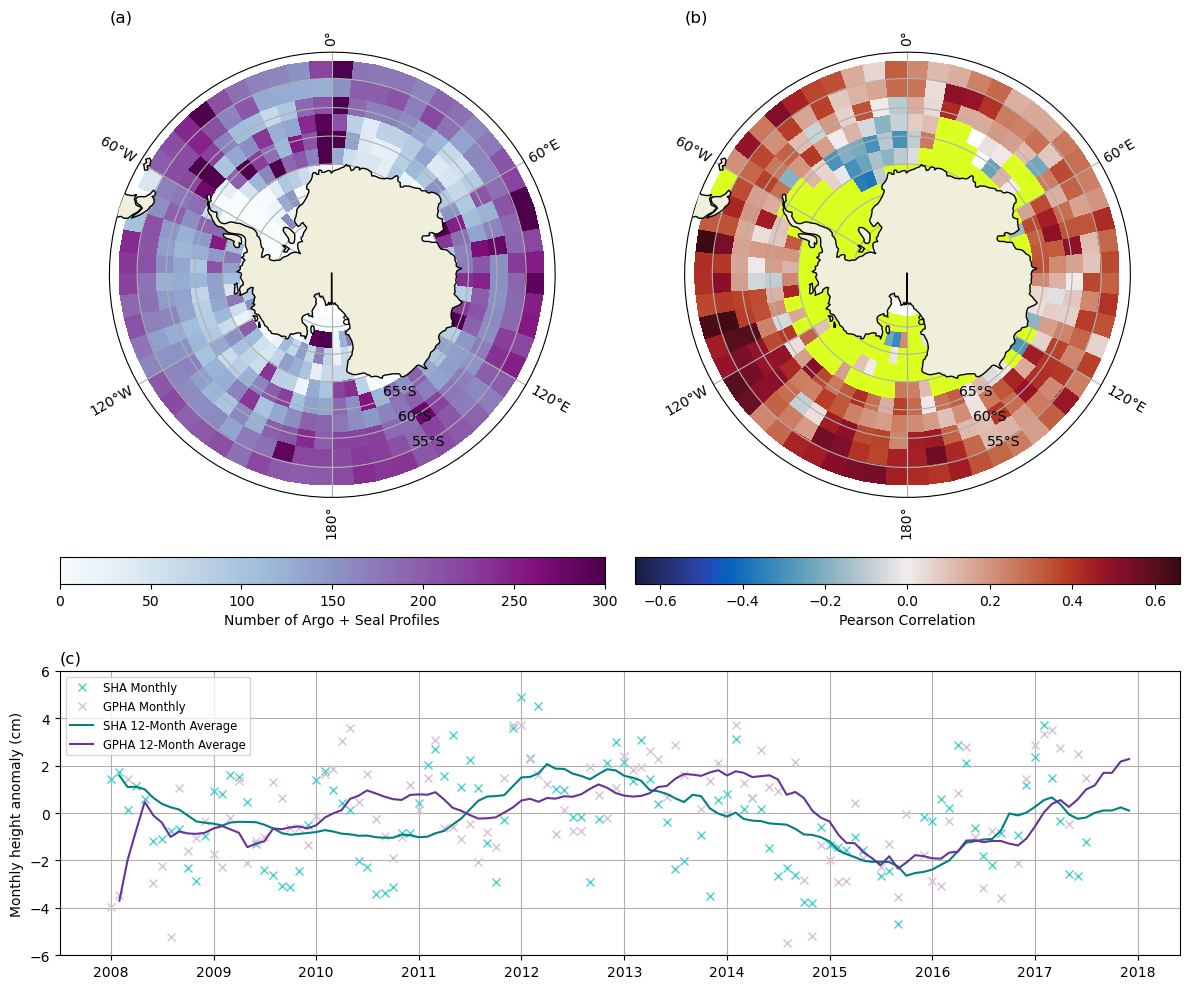

In [16]:
#fig,axs = plt.subplots(1,3,figsize=(20,5),subplot_kw={'projection': ccrs.SouthPolarStereo()})

fig = plt.figure(figsize=(12,10))
axs=[]

gs = fig.add_gridspec(3,2)#,height_ratios=[1,2])
axs.append(fig.add_subplot(gs[0:2, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[0:2, 1],projection=ccrs.SouthPolarStereo()))
#axs.append(fig.add_subplot(gs[2, 0]))
#axs.append(fig.add_subplot(gs[2, 1]))
axs.append(fig.add_subplot(gs[2, 0:2]))

# (c), (d) climatology
#cmt_compare(sha_gph.where(~in_siz),axs[2],axs[3])

# (a) profile count
pfns.sp(axs[0],sha_gph.profile_cnt.sum(('time')),vmin=0,vmax=300,cbar="Number of Argo + Seal Profiles",cmap='BuPu',cbar_orientation='horizontal')

# create a mask to hide places with less than 6 profiles
mask6_ = xr.ones_like(n_months_with_gph)
mask6 = mask6_.where(n_months_with_gph<n_cutoff,np.nan)
cmap6 = 'gist_ncar'

# (b) correlation
pfns.sp(axs[1],xr.corr(sha_corr,gph_corr,dim='time'),cmap=cmocean.cm.balance,cbar='Pearson Correlation',cbar_orientation='horizontal')
mask6.plot(ax=axs[1],transform=ccrs.PlateCarree(),x='longitude',y='latitude',cmap=cmap6,add_colorbar=False)

sample_rg = rg('Sample Region', [65,80,-55,-50], max_elevation=-500)# [68,78,-53.5,-50])

sample_rg.timeseries_compare(sha_gph,annual=False,fig=fig,ax=axs[2],crop_times=True)
axs[2].set_ylim([-6,6])
#fig.savefig('plots/figure3e.png',dpi=200,transparent=True,bbox_inches='tight')
axs[0].set_title('(a)',loc='left')
axs[1].set_title('(b)',loc='left')
axs[2].set_title('(c)',loc='left')
#axs[3].set_title('(d)',loc='left')
#axs[4].set_title('(e)',loc='left')

#fig.savefig('plots/figure3abc.png',dpi=200,transparent=True,bbox_inches='tight')
#fig.patches.extend([plt.Rectangle((0.785,0.75),0.02,0.04,
                                  #fill=False, color='r', alpha=0.9, zorder=1000,
                                  #transform=fig.transFigure, linewidth=3, figure=fig)])

plt.tight_layout()


In [16]:
corr = xr.corr(sha_corr,gph_corr,dim='time')
pval = xss.pearson_r_p_value(sha_corr,gph_corr,dim='time',skipna=True)
total_boo = ~np.isnan(corr)
total = sum(sum(total_boo)).item()
greater_than_50 = sum(sum((corr > 0.5))).item()
greater_than_25 = sum(sum((corr > 0.25))).item()
p_greater_than_50 = sum(sum((pval > 0.5))).item()

# percentage greater than 25% corr
greater_than_25/total

0.48562300319488816

In [22]:
# percentage greater than 25% corr above 65deg
corrn = corr.where(corr.latitude > -60,drop=True)
totaln_boo = ~np.isnan(corrn)
totaln = sum(sum(totaln_boo)).item()
greater_than_25n = sum(sum((corrn > 0.25))).item()
greater_than_25n/totaln


0.6348314606741573

In [23]:
corrs = corr.sel(longitude = slice(-130,-60))
corrn = corrs.where(corrs.latitude > -60,drop=True)
totaln_boo = ~np.isnan(corrn)
totaln = sum(sum(totaln_boo)).item()
greater_than_25n = sum(sum((corrn > 0.25))).item()
greater_than_25n/totaln


0.8235294117647058

In [26]:
corrn.mean()

<xarray.DataArray ()> Size: 8B
array(0.42803698)

In [14]:
# BASIN WIDE VALIDATION
wss = rg('Weddell Sea Sector',[-70, 20, -90, -50])
ios = rg('Indian Ocean Sector',[20, 90, -90, -50])
aab = rg('Australian-Antarctic basin',[90, 150, -90, -50])
rss = rg('Ross Sea Sector',[150,-120, -90, -50])
bas = rg('Bellingshausen-Amundsen Sector', [-120, -70, -90, -50])

(-4.0, 4.0)

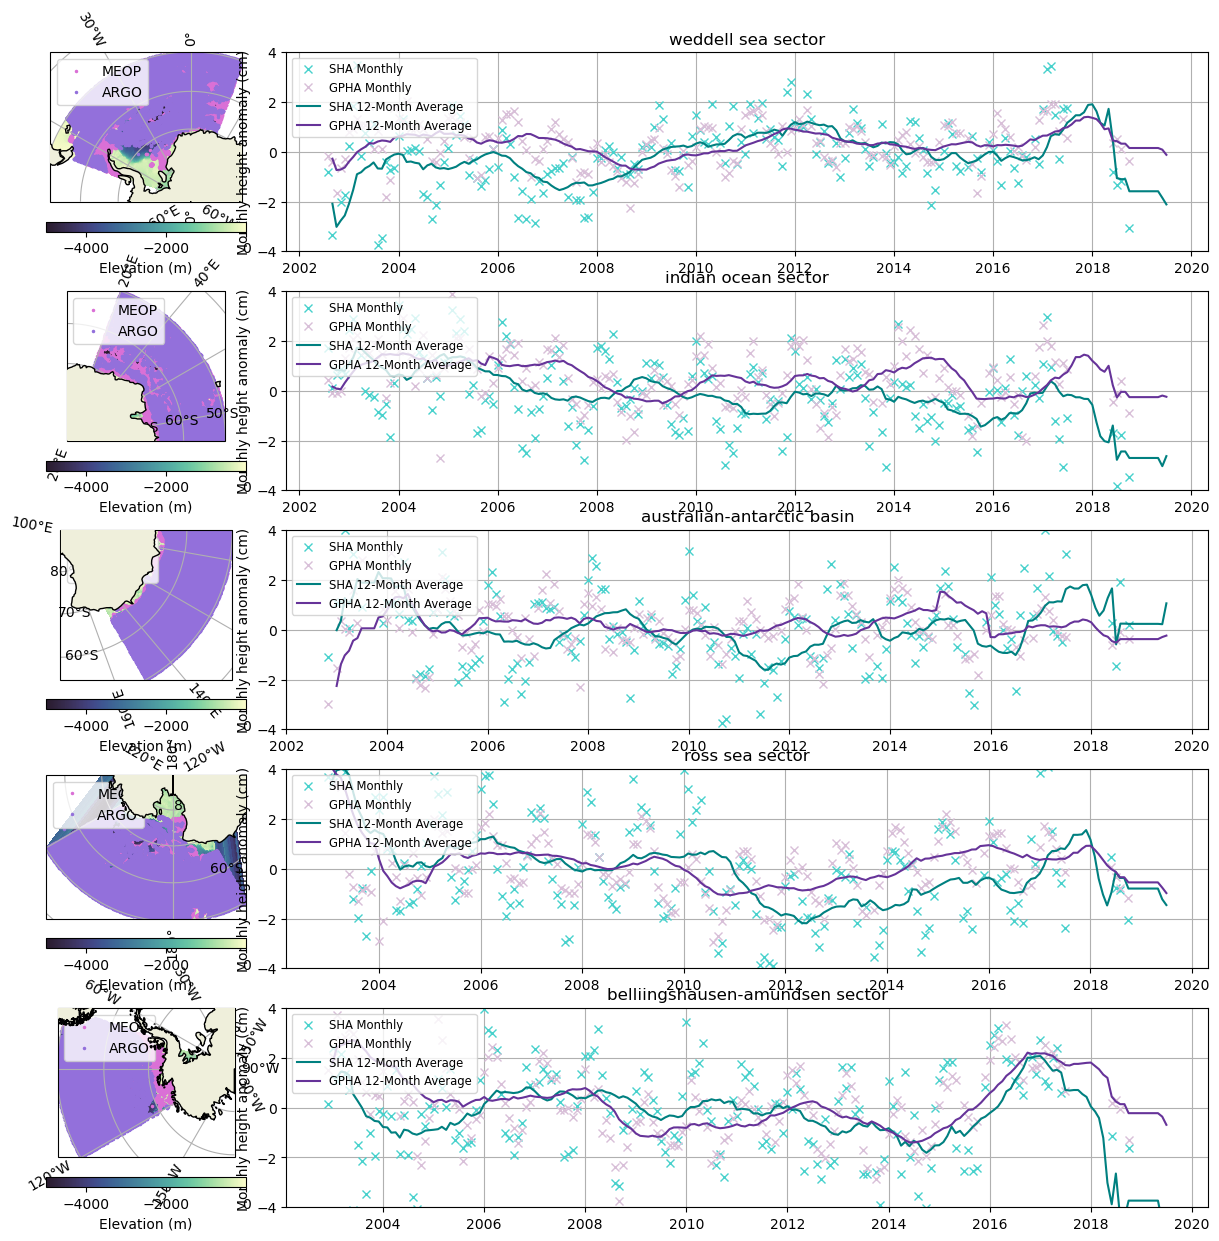

In [15]:
fig = plt.figure(figsize=(15,15))
axs=[]

gs = fig.add_gridspec(5,5)#,height_ratios=[1,2])
axs.append(fig.add_subplot(gs[0, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[0, 1:5]))

axs.append(fig.add_subplot(gs[1, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[1, 1:5]))

axs.append(fig.add_subplot(gs[2, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[2, 1:5]))

axs.append(fig.add_subplot(gs[3, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[3, 1:5]))

axs.append(fig.add_subplot(gs[4, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[4, 1:5]))

#ax=axs[0]
fig,ax_ = wss.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5),ax=axs[0])
fig, ax_ = wss.timeseries_compare(sha_gph,annual=False,ax=axs[1])
axs[1].set_title('weddell sea sector')
axs[1].set_ylim([-4,4])

fig,ax_ = ios.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5),ax=axs[2])
fig, ax_ = ios.timeseries_compare(sha_gph,annual=False,ax=axs[3])
axs[3].set_title('indian ocean sector')
axs[3].set_ylim([-4,4])

fig,ax_ = aab.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5),ax=axs[4])
fig, ax_ = aab.timeseries_compare(sha_gph,annual=False,ax=axs[5])
axs[5].set_title('australian-antarctic basin')
axs[5].set_ylim([-4,4])

fig,ax_ = rss.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5),ax=axs[6])
fig, ax_ = rss.timeseries_compare(sha_gph,annual=False,ax=axs[7])
axs[7].set_title('ross sea sector')
axs[7].set_ylim([-4,4])

fig,ax_ = bas.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5),ax=axs[8])
fig, ax_ = bas.timeseries_compare(sha_gph,annual=False,ax=axs[9])
axs[9].set_title('belliingshausen-amundsen sector')
axs[9].set_ylim([-4,4])





Text(0.5, 1.0, 'decrease')

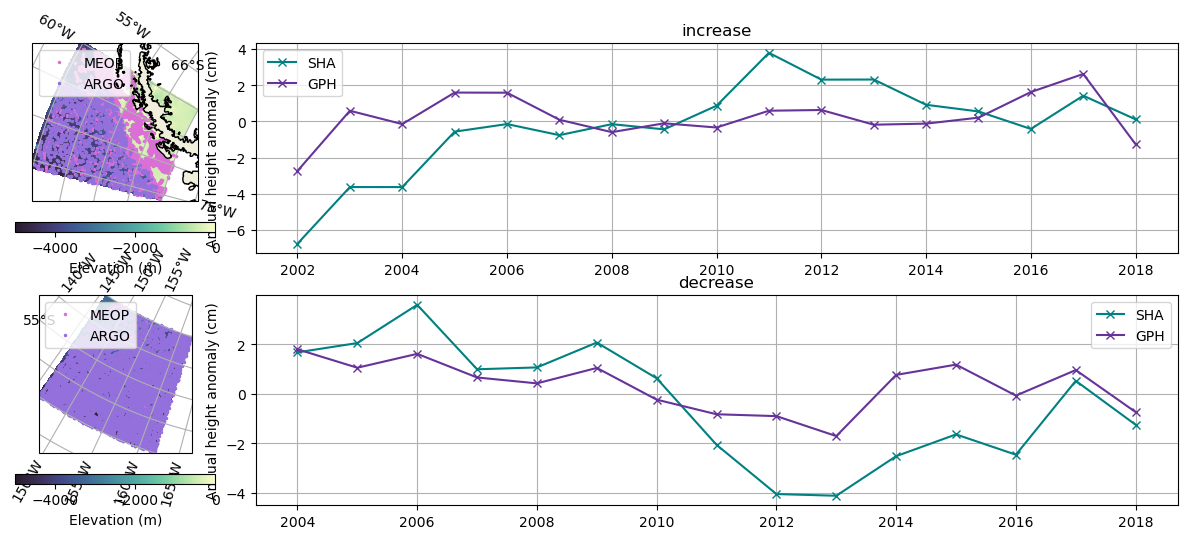

In [16]:
fig = plt.figure(figsize=(15,6))
axs=[]

hi = rg('high',[-76, -60, -68, -60])
lo = rg('low',[-162, -146, -60, -50])

gs = fig.add_gridspec(2,5)#,height_ratios=[1,2])
axs.append(fig.add_subplot(gs[0, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[0, 1:5]))

axs.append(fig.add_subplot(gs[1, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[1, 1:5]))


#ax=axs[0]
fig,ax_ = hi.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5),ax=axs[0])
fig, ax_ = hi.timeseries_compare(sha_gph,annual=True,ax=axs[1],crop_times=False)
axs[1].set_title('increase')

fig,ax_ = lo.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5),ax=axs[2])
fig, ax_ = lo.timeseries_compare(sha_gph,annual=True,ax=axs[3],crop_times=False)
axs[3].set_title('decrease')


/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


Text(0.5, 1.0, 'GPH trend')

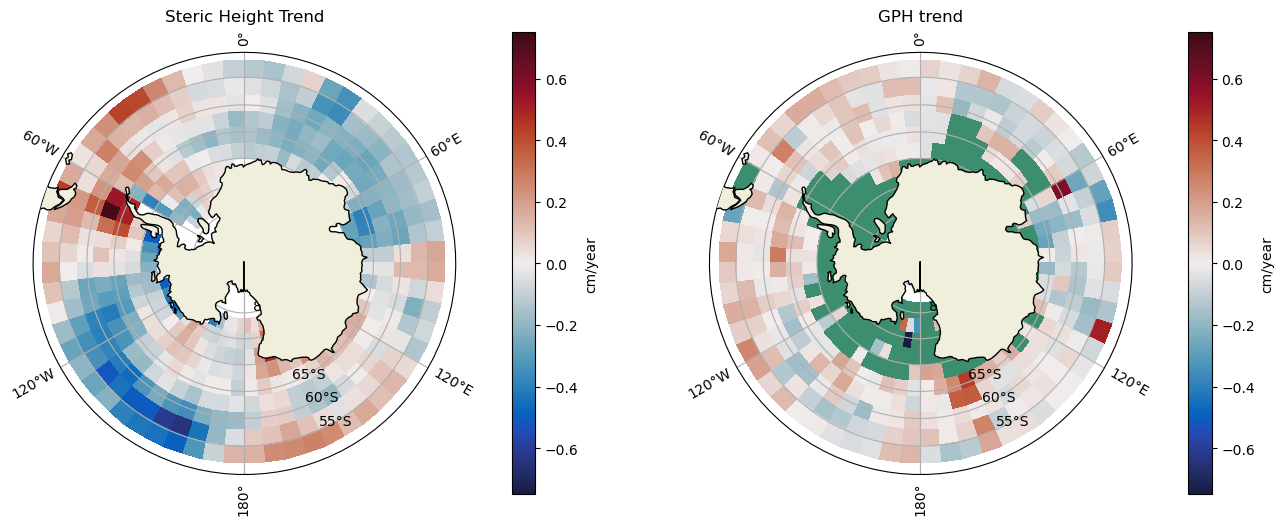

In [17]:
ns_2_yr = lambda x: x * 1e9 * 60 * 60 * 24 * 365.25
p = sha_gph.sha.polyfit(dim='time',deg=1)
p_gph = sha_gph.profile_gpha.polyfit(dim='time',deg=1)
m = p.polyfit_coefficients.sel(degree=1)
m_gph = p_gph.polyfit_coefficients.sel(degree=1)

import cmocean
fig,axs = plt.subplots(1,2,figsize=(16,6),subplot_kw={'projection': ccrs.SouthPolarStereo()})
pfns.sp(axs[0],ns_2_yr(m),title='Steric Height Trend',cmap=cmocean.cm.balance,cbar='cm/year',cbar_orientation='vertical',vmax=0.75)
pfns.sp(axs[1],ns_2_yr(m_gph),title='GPH Trend',cmap=cmocean.cm.balance,cbar='cm/year',cbar_orientation='vertical',vmax=0.75)
mask6.plot(ax=axs[1],transform=ccrs.PlateCarree(),x='longitude',y='latitude',cmap=cmap6,add_colorbar=False)
axs[1].set_title('GPH trend')


In [18]:
def timeseries_with_cmt(region):
    
    ds = region.crop_da(sha_gph)
    fig, axs = plt.subplots(4,2,figsize=(16,10),gridspec_kw={'width_ratios': [2,1]})

    data_monthly = ds.where(~np.isnan(ds.sha))
    data_monthly_mean = data_monthly.mean(['latitude','longitude'])
    
    # climatology
    cmt = data_monthly.groupby('time.month').mean('time',skipna=True)
    cmt_mean = cmt.mean(['latitude','longitude'])

    #
    def plot_monthly(ax,var,c,cl,ylabel,mkr='-'):
        ax.plot(data_monthly.time,data_monthly_mean[var].to_numpy(),mkr,c=c)
        ax.plot(data_monthly.time,data_monthly_mean[var].rolling(time=12,min_periods=6).mean(),'-',c=cl)
        ax.set_ylabel(ylabel)
        ax.grid()
        
    def plot_climatology(ax,var,c,cl,mkr='-'):
        for grp in data_monthly_mean.groupby('time.year'):
            data = grp[1].groupby('time.month').mean()
            ax.plot(data.month,data[var],mkr,label=grp[0],c=cl)
        ax.plot(cmt.month,cmt_mean[var].to_numpy(),'-',c=c)
        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
        ax.set_xlim([0.5,12.5])
        ax.grid()
    
    plot_monthly(axs[0][0],'ssha',c_dota_l,c_dota,'DOTA')
    plot_monthly(axs[1][0],'eha',c_grace_l,c_grace,'EHA')
    plot_monthly(axs[2][0],'sha',c_altimetry_l,c_altimetry,'SHA')
    plot_monthly(axs[3][0],'profile_gpha',c_profiles_l,c_profiles,'GPHA',mkr='x')
    
    plot_climatology(axs[0][1],'ssha',c_dota,c_dota_l)
    plot_climatology(axs[1][1],'eha',c_grace,c_grace_l)
    plot_climatology(axs[2][1],'sha',c_altimetry,c_altimetry_l)
    plot_climatology(axs[3][1],'profile_gpha',c_profiles,c_profiles_l,mkr='x')
    
    
    return fig, axs


In [19]:
def climatology_bar(region,useall=False):
    
    # crop sh dataset to region
    ds = region.crop_da(sha_gph)
    
    # crop profile dataframes to region (to get numbers)
    if not useall:
        # crop to region within satellite data time limits
        meop_crop = region.crop_df(profiles_meop[(profiles_meop.index > pd.to_datetime(sta.item())) & (profiles_meop.index < pd.to_datetime(fin.item()))])
        argo_crop = region.crop_df(profiles_argo[(profiles_argo.index > pd.to_datetime(sta.item())) & (profiles_argo.index < pd.to_datetime(fin.item()))])
    else:
        meop_crop = region.crop_df(profiles_meop)
        argo_crop = region.crop_df(profiles_argo)
    
    # get numbers of profiles
    months = np.arange(1,13)
    counts = lambda df: [len(df[df.index.month==m]) for m in months]
    n_meop = counts(meop_crop)
    n_argo = counts(argo_crop)
    
    # only include values where we have both profile and sha data
    if useall:
        data_masked = ds.where(~np.isnan(ds.profile_gpha))
    else:
        data_masked = ds.where(~np.isnan(ds.profile_gpha) & ~np.isnan(ds.sha))
        
    # compute detrended timeseries' for better climatology
    ds = ds.assign(gph_detrended = utls.detrend_dim(ds.profile_gpha, 'time', deg=1))
    ds = ds.assign(sha_detrended = utls.detrend_dim(ds.sha, 'time', deg=1))
    ds = ds.assign(ssha_detrended = utls.detrend_dim(ds.ssha, 'time', deg=1))
    
    
    climatology = ds.groupby('time.month').mean('time',skipna=True)

    fig, axs = plt.subplots(2,1,figsize=(12,7),gridspec_kw={'height_ratios': [1,1.5]})

    data = climatology.mean(['latitude','longitude'])
    counts = climatology.profile_cnt.sum(['latitude','longitude']).to_numpy()
    
    pfns.climatology(axs[0],[data.sha_detrended.to_numpy(),data.ssha_detrended.to_numpy(),data.gph_detrended.to_numpy()],['SHA','SSH','GPHA'],[c_altimetry,c_dota,c_profiles],twinx=False)

    w=0.6
    axs[1].bar(months, n_meop, w, label='All MEOP profiles', color=c_meop)
    axs[1].bar(months, n_argo,w, label='All ARGO profiles', bottom=n_meop, color=c_soccom)

    axs[1].grid()
    axs[1].set_xticks(months, ['J','F','M','A','M','J','J','A','S','O','N','D'])
    axs[1].legend(loc='best')
    axs[1].set_ylabel('Number of profiles')

    return fig


In [24]:
def timeseries_bar(region,annual=True,useall=False):
    
    ds = region.crop_da(sha_gph)
    if useall:
        ds = ds.sel(time=slice('2008-04-01','2022-03-31'))
    else:
        ds = ds.sel(time=slice('2008-01-01','2017-12-31'))
    
    fig, axs = plt.subplots(2,1,figsize=(12,6))

    # restrict altimetry to only where there are profiles
    if useall:
        data_masked = ds.where(~np.isnan(ds.profile_gpha))
    else:
        data_masked = ds.where(~np.isnan(ds.profile_gpha) & ~np.isnan(ds.sha))
            
    # take annual mean
    data_spatial = data_masked.groupby('time.year').mean('time',skipna=True) if annual else data_masked

    # spatial average
    data = data_spatial.mean(['latitude','longitude'])
    
    # sum counts for bar plot
    counts_annual = data_spatial.profile_cnt.sum(['latitude','longitude']).to_numpy()
    
    plot_time = data.year if annual else data.time
    
    if not annual:
        counts_monthly = data_masked.profile_cnt.sum(['latitude','longitude']).to_numpy()
        counts_quarterly = sum(counts_monthly.reshape([3,int(len(counts_monthly)/3)]))
        time_quarterly = data.time.to_numpy().reshape([int(len(counts_monthly)/3),3])[:,1]
    
    # plot sh and gph on different axes
    def plot(ax,var,c,title,marker='x-'):
        ax.plot(plot_time,data[var].to_numpy(),marker,c=c,label=title)
        
    
    # plot bar to show number of profiles
    if annual:
        plot(axs[0],'sha',c_altimetry,'SHA')
        plot(axs[0],'profile_gpha',c_profiles,'GPH')
        axs[0].grid()
        axs[0].legend()
        axs[0].set_ylabel('Annual height anomaly (cm)')
        axs[1].bar(plot_time,counts_annual,color=c_profiles)
        axs[1].set_ylabel('Number of profiles')
        axs[1].grid()
        axs[1].set_xlim(axs[0].get_xlim())
    else:
        plot(axs[0],'sha',c_altimetry_l,'SHA',marker='x')
        plot(axs[0],'profile_gpha',c_profiles_l,'GPHA',marker='x')
        axs[0].legend()
        data.sha.rolling(time=3,min_periods=2).mean().plot(ax=axs[0],label="SHA 12-Mo. Moving Av.",c=c_altimetry)
        data.profile_gpha.rolling(time=3,min_periods=2).mean().plot(ax=axs[0],label="GPHA 12-Mo. Moving Av.",c=c_profiles)
        axs[0].grid()
        axs[0].set_ylabel('Monthly height anomaly (cm)')
        
        axs[1].bar(np.arange(len(counts_quarterly)),counts_quarterly,color=c_profiles_l)
        axs[1].set_ylabel('Number of profiles')
        axs[1].grid()
        axs[1].set_xticks(np.arange(len(counts_quarterly))[::4])
        axs[1].set_xticklabels(map(lambda t: pd.to_datetime(t).strftime('%m-%Y'),time_quarterly[::4]))
    
    return fig, axs


In [21]:
def climatology_bar(region,useall=False):
    
    # crop sh dataset to region
    ds = region.crop_da(sha_gph)
    
    # crop profile dataframes to region (to get numbers)
    if not useall:
        # crop to region within satellite data time limits
        meop_crop = region.crop_df(profiles_meop[(profiles_meop.index > pd.to_datetime(sta.item())) & (profiles_meop.index < pd.to_datetime(fin.item()))])
        argo_crop = region.crop_df(profiles_argo[(profiles_argo.index > pd.to_datetime(sta.item())) & (profiles_argo.index < pd.to_datetime(fin.item()))])
    else:
        meop_crop = region.crop_df(profiles_meop)
        argo_crop = region.crop_df(profiles_argo)
    
    # get numbers of profiles
    months = np.arange(1,13)
    counts = lambda df: [len(df[df.index.month==m]) for m in months]
    n_meop = counts(meop_crop)
    n_argo = counts(argo_crop)
    
    # only include values where we have both profile and sha data
    if useall:
        data_masked = ds.where(~np.isnan(ds.profile_gph))
    else:
        data_masked = ds.where(~np.isnan(ds.profile_gph) & ~np.isnan(ds.sha))
        
    # compute detrended timeseries' for better climatology
    ds = ds.assign(gph_detrended = utls.detrend_dim(ds.profile_gpha, 'time', deg=1))
    ds = ds.assign(sha_detrended = utls.detrend_dim(ds.sha, 'time', deg=1))
    ds = ds.assign(ssha_detrended = utls.detrend_dim(ds.ssha, 'time', deg=1))
    
    
    climatology = ds.groupby('time.month').mean('time',skipna=True)

    fig, axs = plt.subplots(2,1,figsize=(12,7),gridspec_kw={'height_ratios': [1,1.5]})

    data = climatology.mean(['latitude','longitude'])
    counts = climatology.profile_cnt.sum(['latitude','longitude']).to_numpy()
    
    pfns.climatology(axs[0],[data.sha_detrended.to_numpy(),data.ssha_detrended.to_numpy(),data.gph_detrended.to_numpy()],['SHA','SSH','GPHA'],[c_altimetry,c_dota,c_profiles],twinx=False)

    w=0.6
    axs[1].bar(months, n_meop, w, label='All MEOP profiles', color=c_meop)
    axs[1].bar(months, n_argo,w, label='All ARGO profiles', bottom=n_meop, color=c_soccom)

    axs[1].grid()
    axs[1].set_xticks(months, ['J','F','M','A','M','J','J','A','S','O','N','D'])
    axs[1].legend(loc='best')
    axs[1].set_ylabel('Number of profiles')

    return fig


c:\Users\eejco\Anaconda3\envs\sha-env\Lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


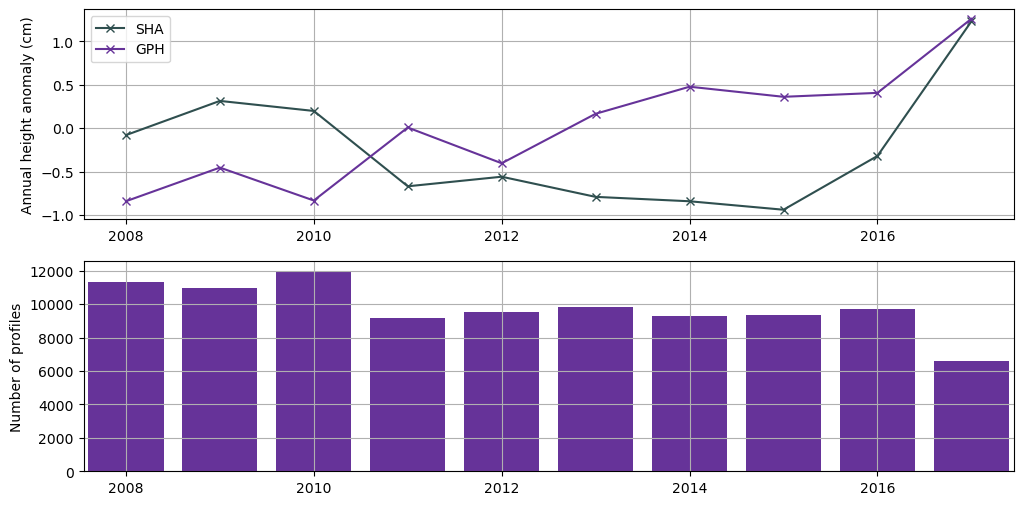

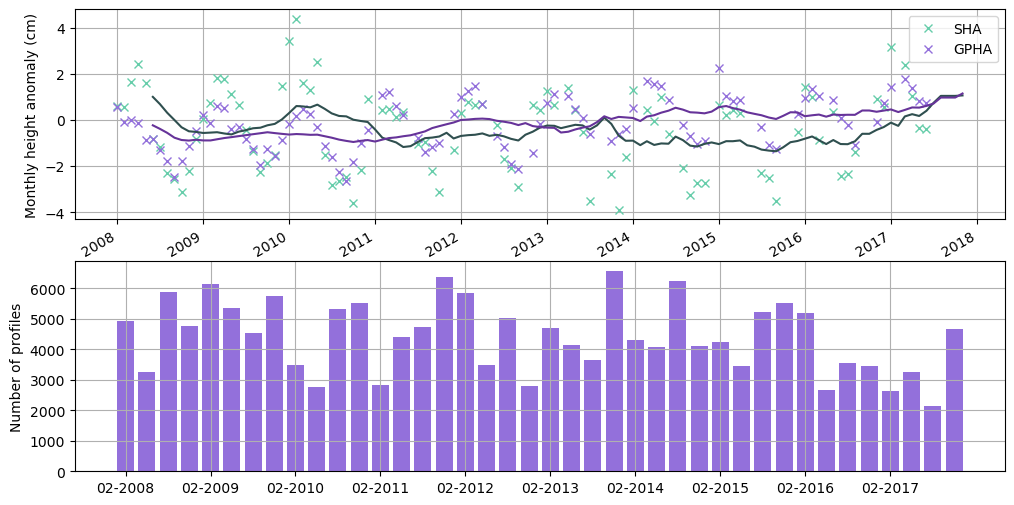

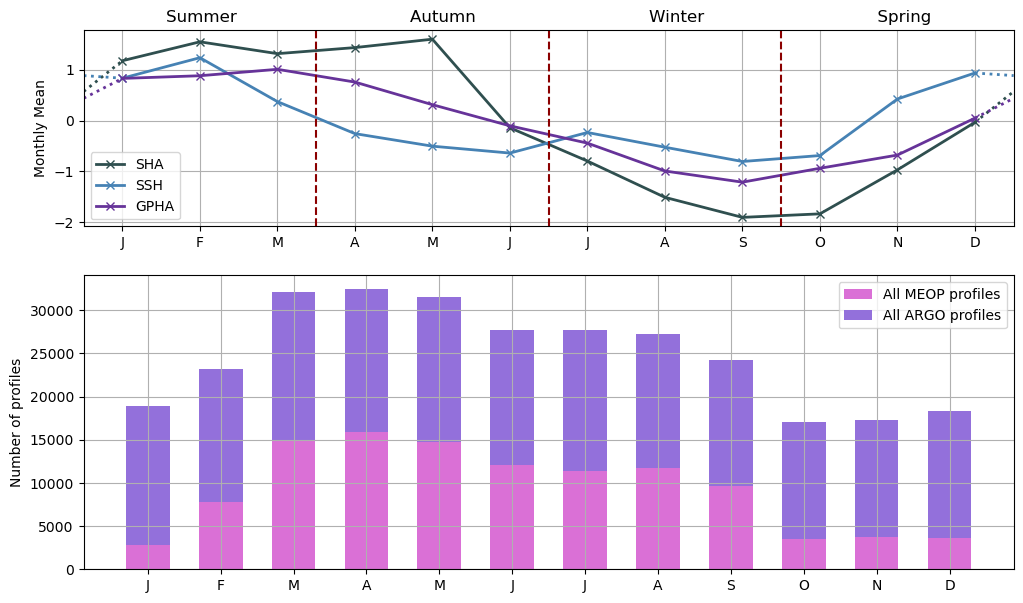

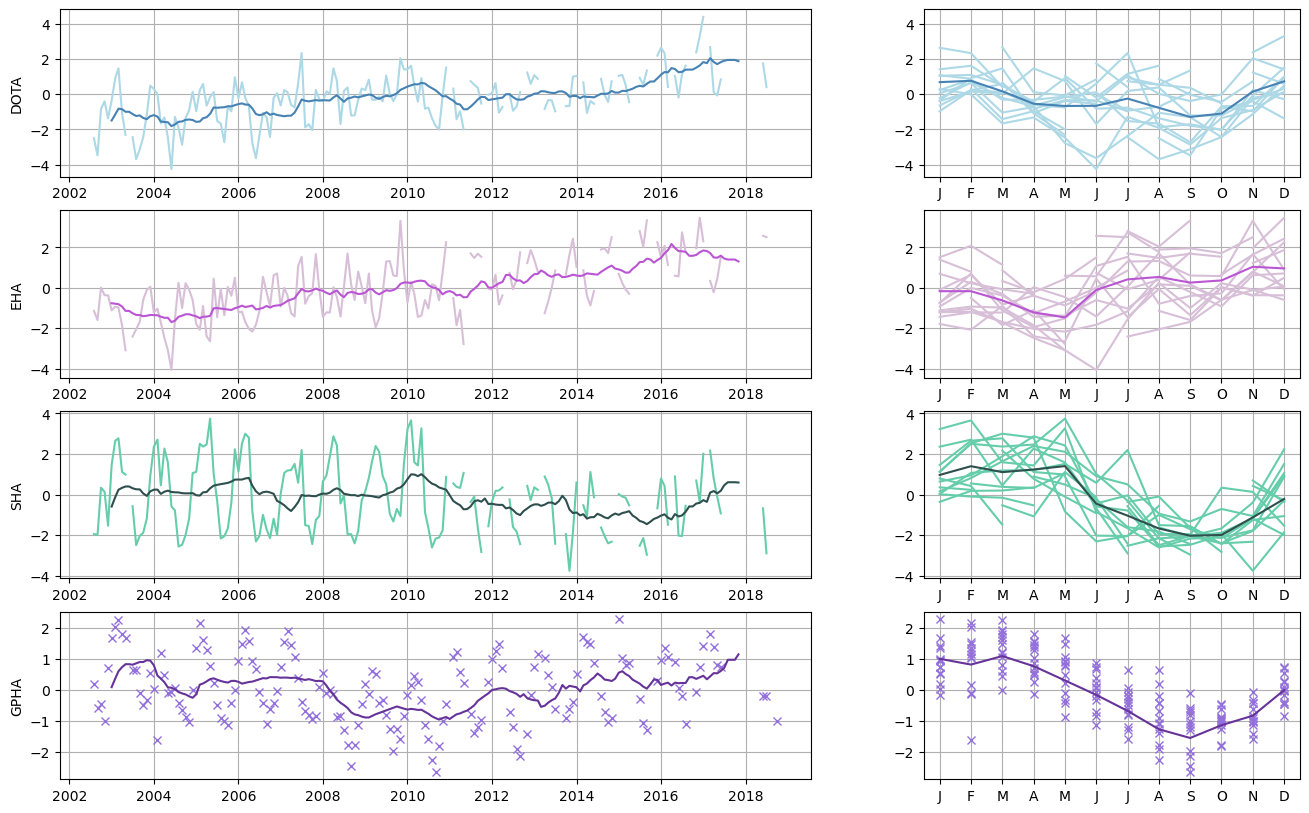

In [ ]:
p = sha.sha.polyfit(dim='time',deg=1)
m = p.polyfit_coefficients.sel(degree=1)

import cmocean
fig,axs = plt.subplots(figsize=(6,6),subplot_kw={'projection': ccrs.SouthPolarStereo()})
pfns.sp(axs,ns_2_yr(m),title='Steric Height Trend',cmap=cmocean.cm.balance,cbar='cm/year',cbar_orientation='vertical',vmax=0.75)

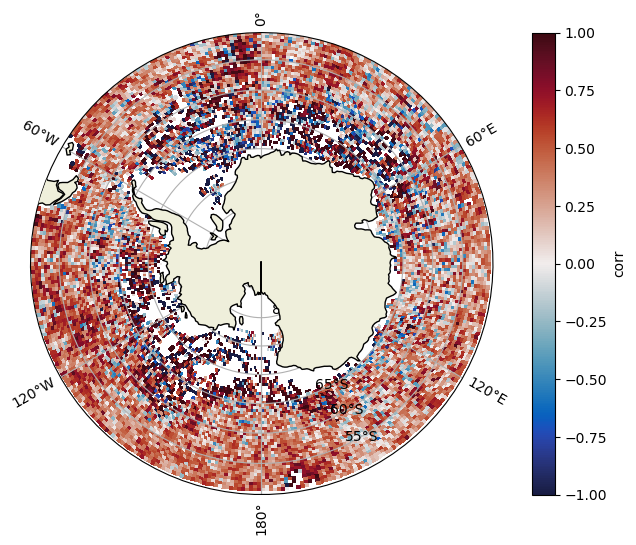

In [315]:
fig,ax = plt.subplots(figsize=(10,6),subplot_kw={'projection': ccrs.SouthPolarStereo()})
pfns.sp(ax,xr.corr(sha_gph.sha,sha_gph.gpha,dim='time'),cmap=cmocean.cm.balance,cbar='corr',cbar_orientation='vertical')

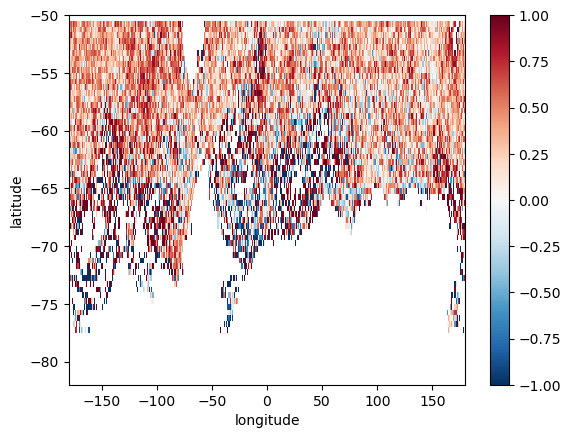

In [309]:
xr.corr(sha_gph.sha,sha_gph.gpha,dim='time').plot()

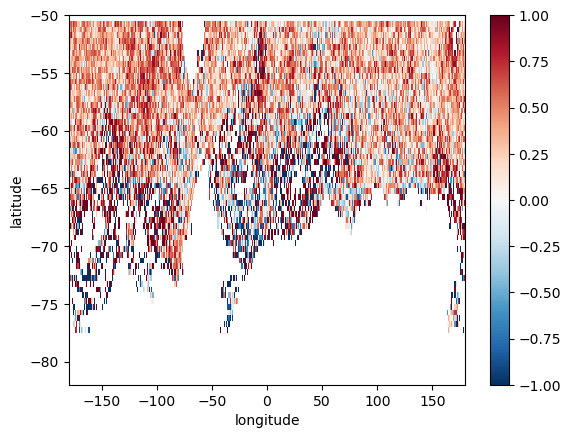

In [307]:
xr.corr(sha_gph.sha,sha_gph.profile_gph,dim='time').plot()

Cropping gebco..
Cropping profile dataframes..
Found MEOP profiles with float IDS: 
[52632 52608 52578 20022 24096 24102 19380 24078 19398 24090 19434 19428
 19422 19446 19440 20016 19998 20010 27492 22044 22014 22074 22008 22050
 22056 22068 22020 21996 22086 22026 27498 22716 22734 22740 26406 26424
 26430 26442 26460 26466 26484 37044 26172 26286 26292 26298 26310 26322
 26328 26334 26358 26340 26346 26352 26364 26370 27378]
Found ARGO profiles with float IDS: 
[5904166]
Plotting bathymetry..
Plotting profile locations.. (markerstyle=x)
Manifesting


c:\Users\eejco\Anaconda3\envs\sha-env\Lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


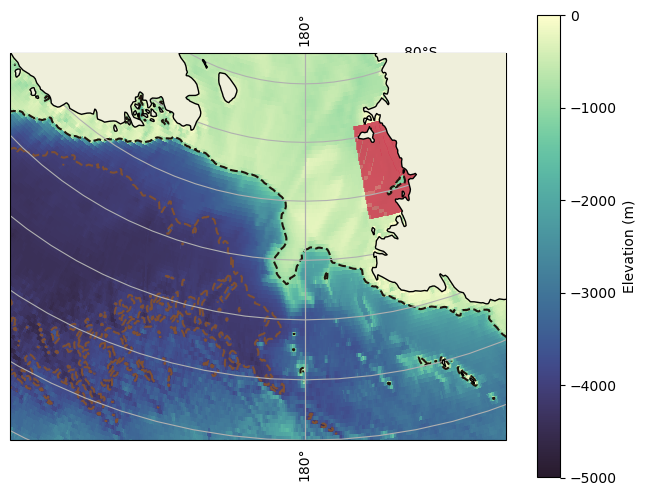

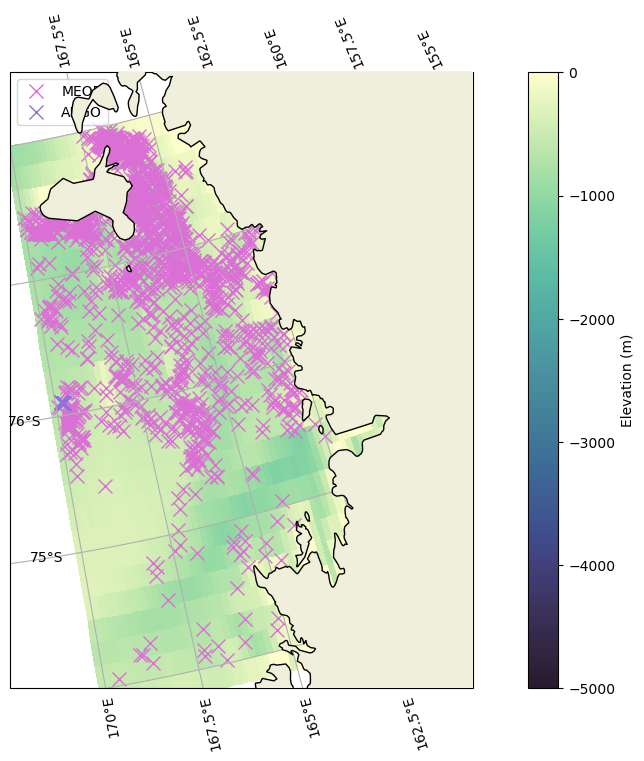

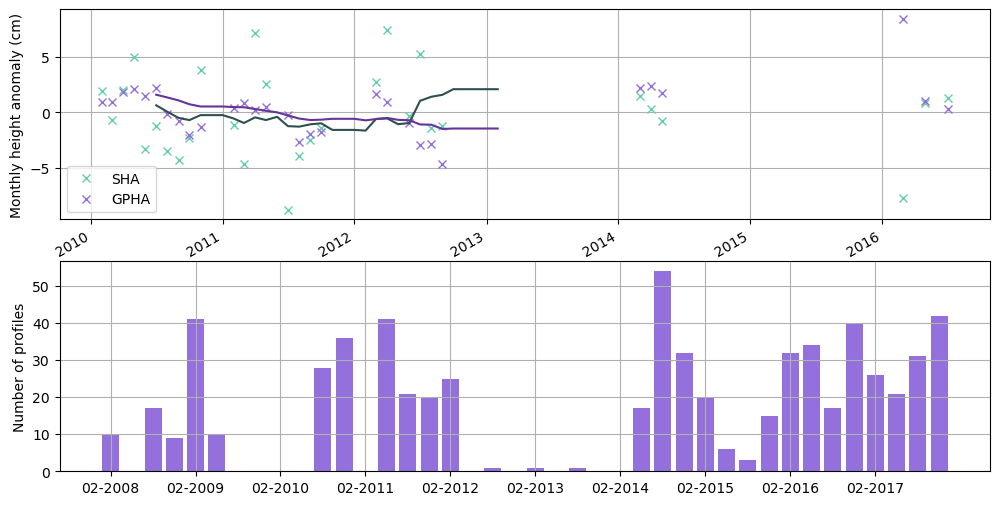

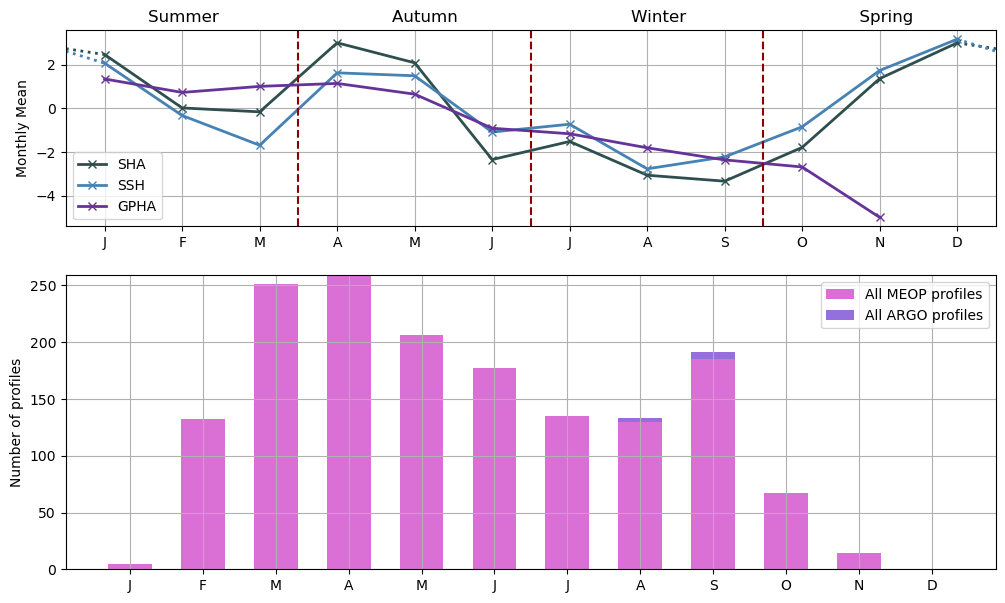

In [30]:
tnb = rg('TNB',[160,170,-78,-74],elevation=gebco_coarse.elevation,min_elevation=-1000)
tnb.plot_region(sea='Ross Sea')
plot_profiles_for_region(tnb,markerstyle='x',markersize=10)#,useall=True)
#rossbit.plot_cmtlgy(sh.gpha)
f2 = timeseries_bar(tnb,annual=False)
f3 = climatology_bar(tnb)

In [11]:
ross_shelf = rg('Ross Ice Shelf',[162,-158,-78,-70],elevation=gebco_coarse.elevation,min_elevation=-1000)
ross_deep = rg('Ross Ice Shelf',[162,-158,-78,-70],elevation=gebco_coarse.elevation,max_elevation=-1000)
ross_all = rg('Ross Ice Shelf',[162,-158,-78,-70],elevation=gebco_coarse.elevation)

In [37]:
ross_profiles=ross_all.crop_df(profiles)
ross_profiles_shelf=ross_shelf.crop_df(profiles)
ross_profiles_deep=ross_deep.crop_df(profiles)

df has no column 'elevation'. trying to interp...


  0%|          | 0/7854 [00:00<?, ?it/s]

In [12]:
ross_profiles['month']=ross_profiles.reset_index().time.dt.month.to_numpy()
ross_profiles_august=ross_profiles[ross_profiles_shelf.month==8]
ross_profiles_august.gph.hist(bins=20)

<AxesSubplot: >

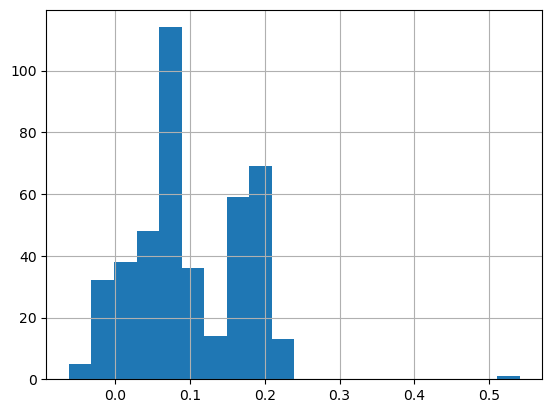

In [39]:
ross_profiles_shelf['month']=ross_profiles_shelf.reset_index().time.dt.month.to_numpy()
ross_profiles_shelf_august=ross_profiles_shelf[ross_profiles_shelf.month==8]
ross_profiles_shelf_august.gph.hist(bins=20)

<AxesSubplot: xlabel='time', ylabel='gph'>

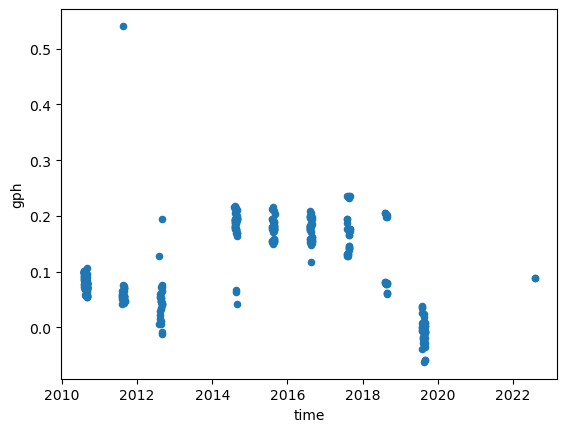

In [53]:
ross_profiles_shelf_august.reset_index().plot.scatter(x='time',y='gph')

In [54]:
ross_profiles_shelf_august

float_type  \
time                                       
2014-08-06 05:27:06.000572160       ARGO   
2014-08-13 01:57:53.000187648       ARGO   
2014-08-19 22:27:50.002395904       ARGO   
2014-08-26 18:58:49.002012416       ARGO   
2014-08-01 09:31:17.001007616       ARGO   
...                                  ...   
2019-08-31 02:09:59.999998000       MEOP   
2019-08-31 21:50:00.000002000       MEOP   
2014-08-19 01:10:00.000001000       MEOP   
2014-08-20 20:40:00.000001000       MEOP   
2014-08-27 01:40:00.000004000       MEOP   

                                                                        filename  \
time                                                                               
2014-08-06 05:27:06.000572160  ../data/ARGO/aoml/5904150/profiles/D5904150_03...   
2014-08-13 01:57:53.000187648  ../data/ARGO/aoml/5904150/profiles/D5904150_03...   
2014-08-19 22:27:50.002395904  ../data/ARGO/aoml/5904150/profiles/D5904150_03...   
2014-08-26 18:58:49.002012416  ../data/ARGO/aoml/5904150/profiles/D5904150_03...   
2014-08-01 09:31:17.001007616  ../data/ARGO/aoml/5904152/profiles/D5904152_03...   
...                                                                          ...   
2019-08-31 02:09:59.999998000                           ct149-922-18_all_prof.nc   
2019-08-31 21:50:00.000002000                           ct149-922-18_all_prof.nc   
2014-08-19 01:10:00.000001000                             ct98-35-13_all_prof.nc   
2014-08-20 20:40:00.000001000                             ct98-35-13_all_prof.nc   
2014-08-27 01:40:00.000004000                             ct98-35-13_all_prof.nc   

                               float_id      lat       lon       gph  month  
time                                                                         
2014-08-06 05:27:06.000572160   5904150 -77.4940 -164.4250  0.216989      8  
2014-08-13 01:57:53.000187648   5904150 -77.4950 -164.4350  0.211850      8  
2014-08-19 22:27:50.002395904   5904150 -77.4960 -164.4450  0.213856      8  
2014-08-26 18:58:49.002012416   5904150 -77.4970 -164.4550  0.211115      8  
2014-08-01 09:31:17.001007616   5904152 -77.5010 -161.9750  0.215086      8  
...                                 ...      ...       ...       ...    ...  
2019-08-31 02:09:59.999998000  00082488 -77.4334  165.9956 -0.009343      8  
2019-08-31 21:50:00.000002000  00082488 -77.5001  166.2359  0.002591      8  
2014-08-19 01:10:00.000001000  00026406 -76.9408  166.7665  0.066272      8  
2014-08-20 20:40:00.000001000  00026406 -77.0392  166.9950  0.063507      8  
2014-08-27 01:40:00.000004000  00026406 -76.9382  167.0506  0.041860      8  

[429 rows x 7 columns]

Interpolating ekevation..


<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

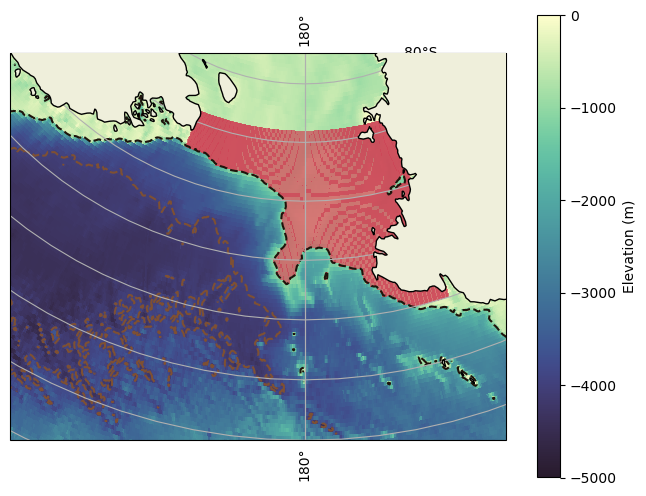

In [6]:
ross_shelf.plot_region(sea='Ross Sea')#extent=[-180,180,-90,-60])

Interpolating ekevation..
Interpolating ekevation..
Interpolating ekevation..


(<Figure size 1600x1000 with 8 Axes>,
 array([[<AxesSubplot: ylabel='DOTA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='EHA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='SHA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='GPHA'>, <AxesSubplot: >]], dtype=object))

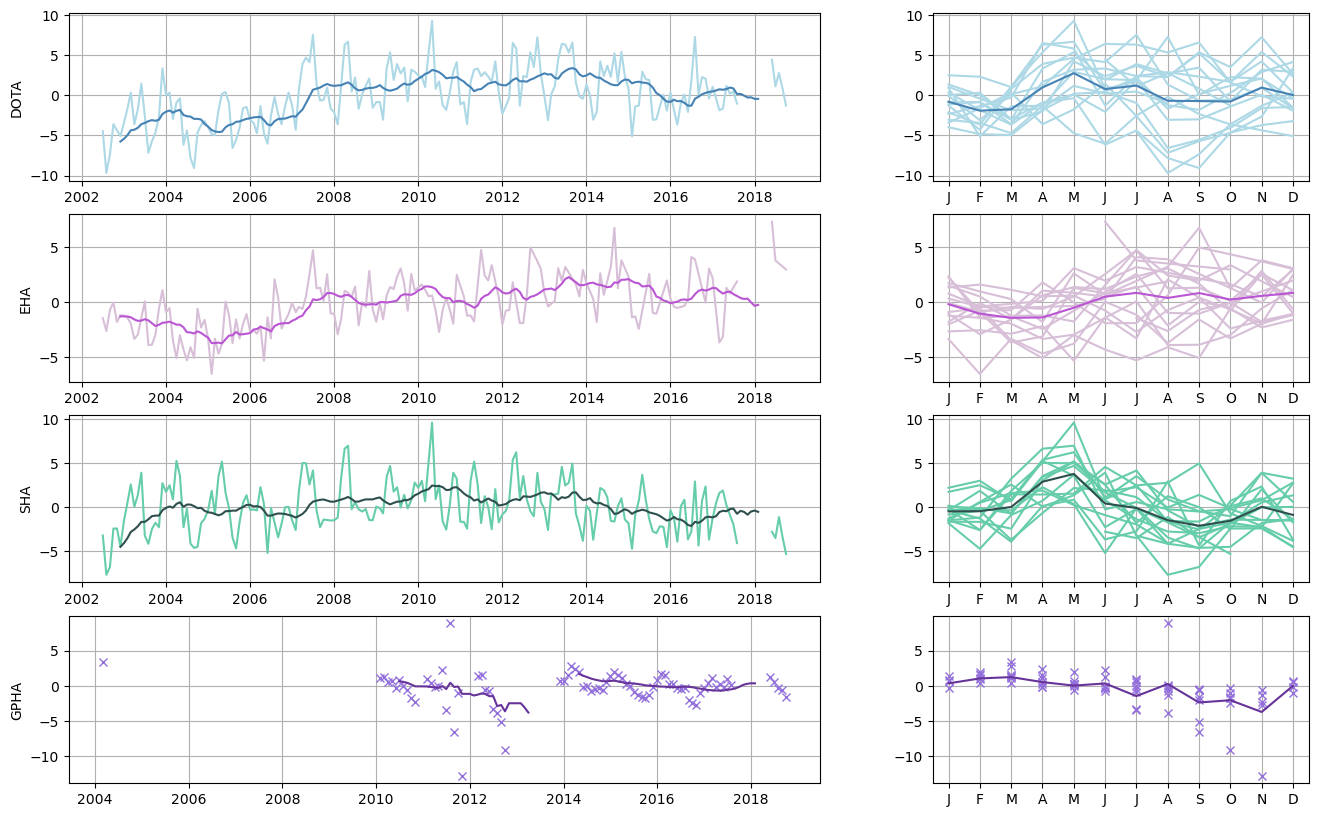

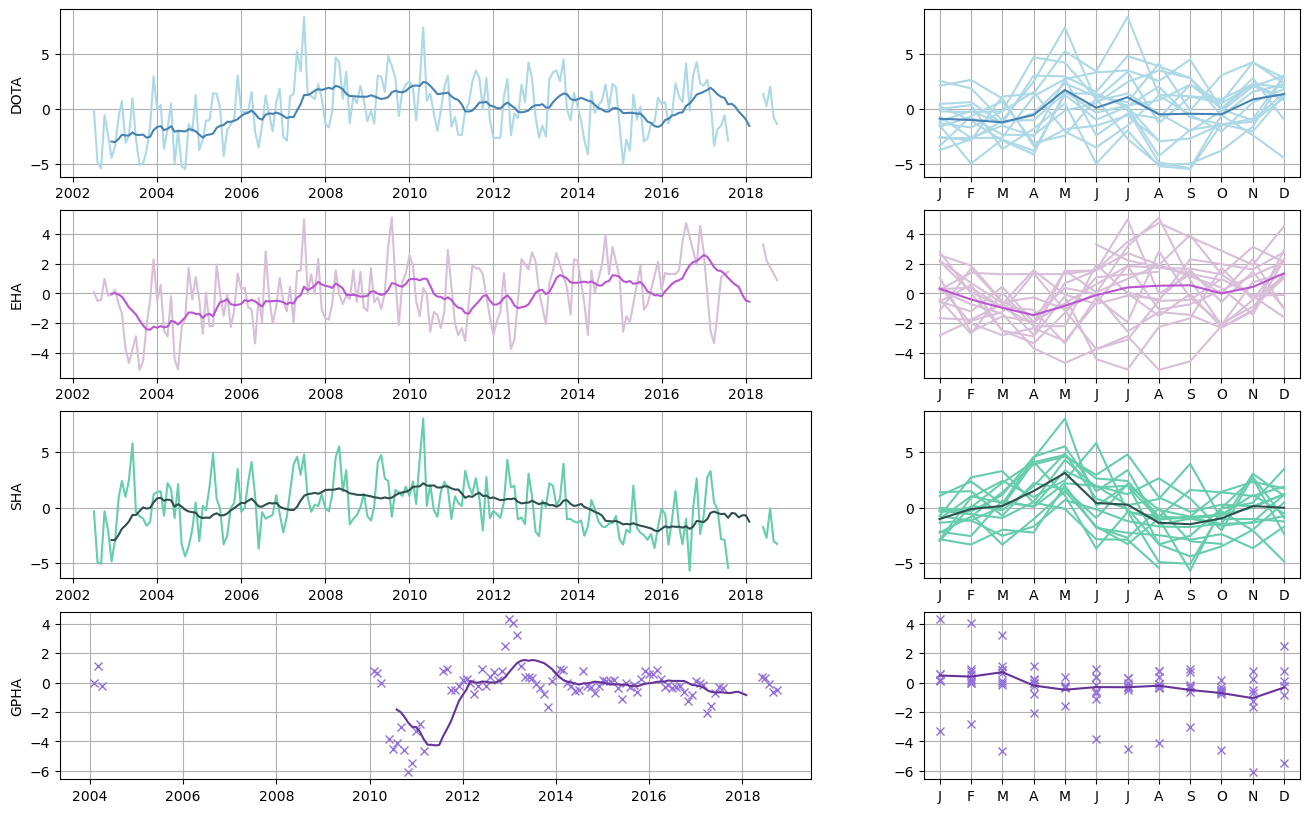

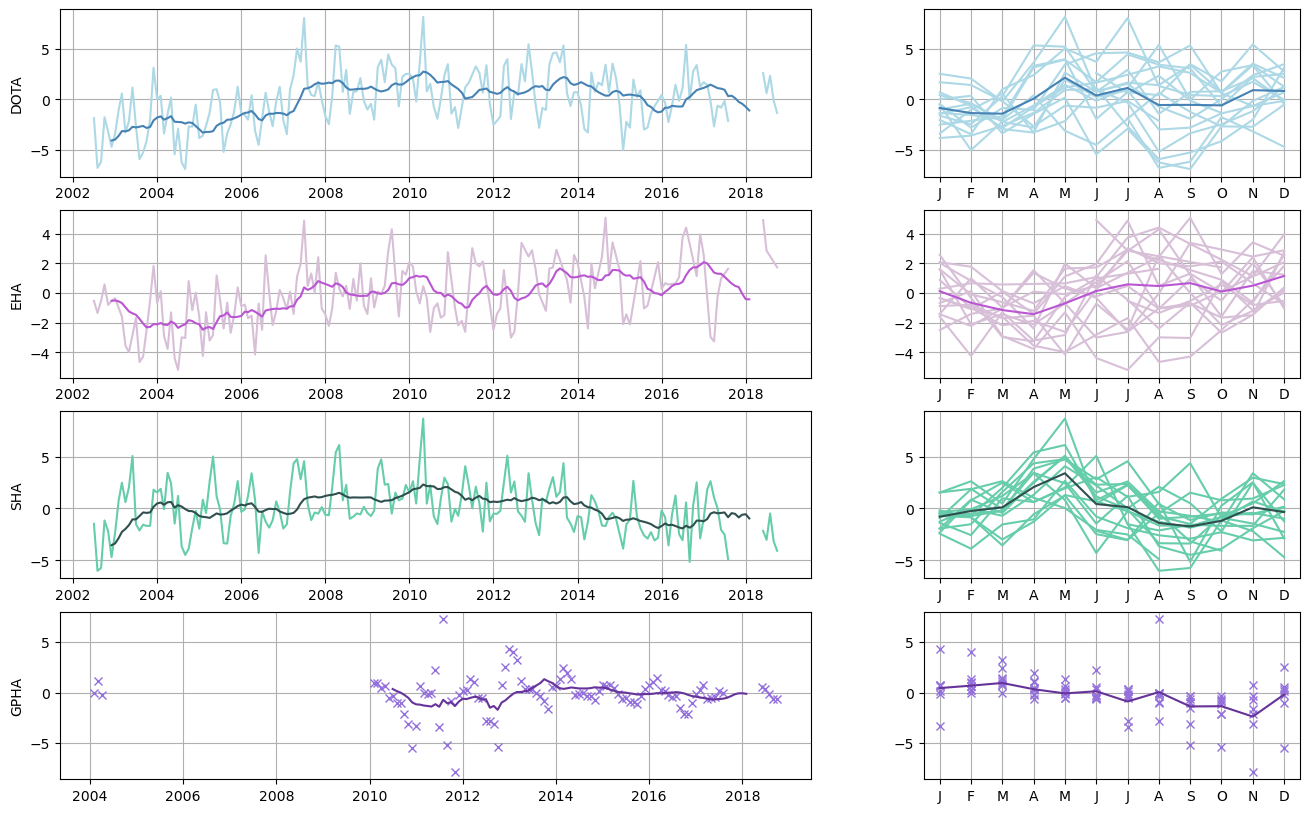

In [299]:
#ross.plot_region()
# f1 = plot_profiles_for_region(ross,markerstyle='x',markersize=6,useall=True)
# f2 = timeseries_bar(ross,annual=False)
# f3 = climatology_bar(ross)
timeseries_with_cmt(ross_shelf)
timeseries_with_cmt(ross_deep)
timeseries_with_cmt(ross_all)

c:\Users\eejco\Anaconda3\envs\sha-env\Lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


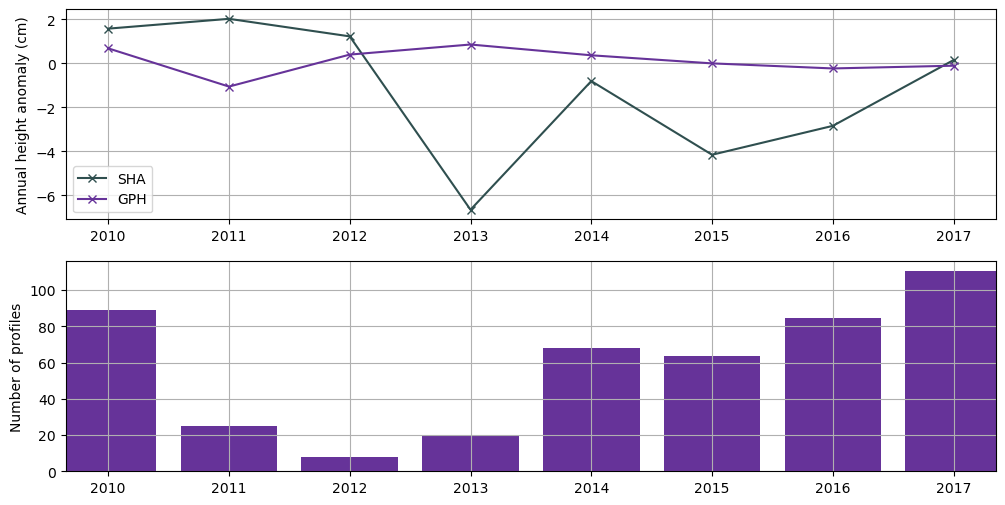

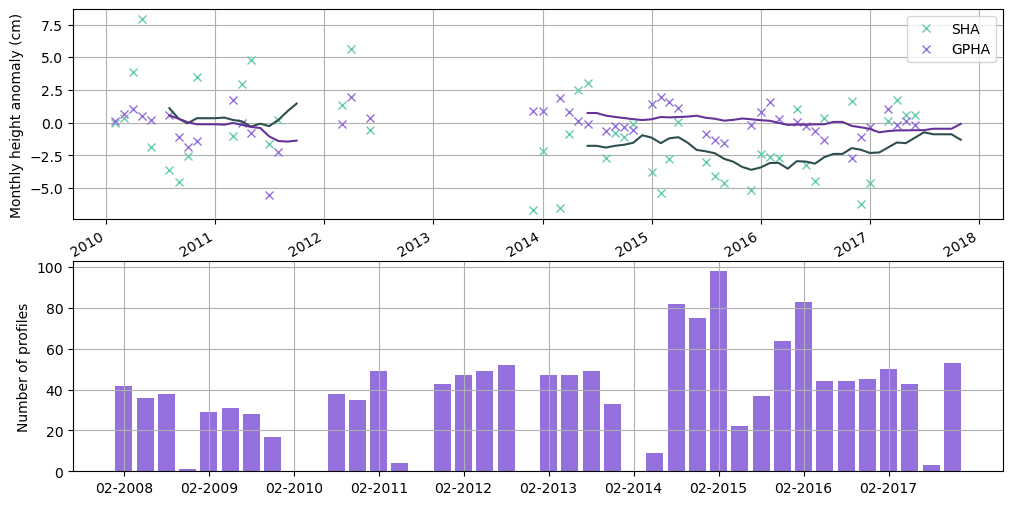

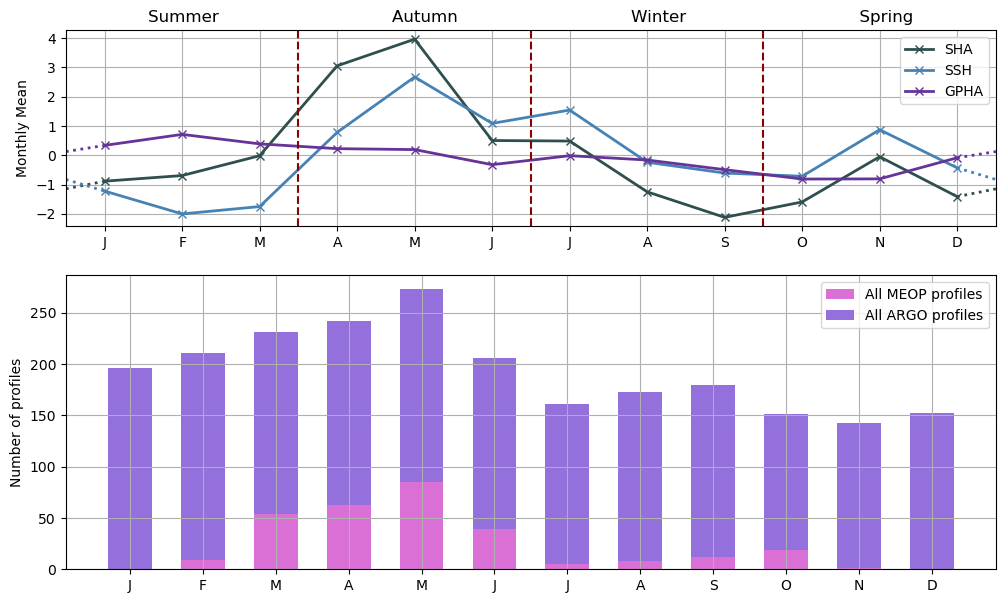

In [31]:
rs = rg("Ross Sea",[170,-150,-85,-70],elevation=gebco_coarse.elevation,min_elevation=-1000)
f2 = timeseries_bar(rs)
f3 = timeseries_bar(rs,annual=False)
f4 = climatology_bar(rs)

Interpolating ekevation..


<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

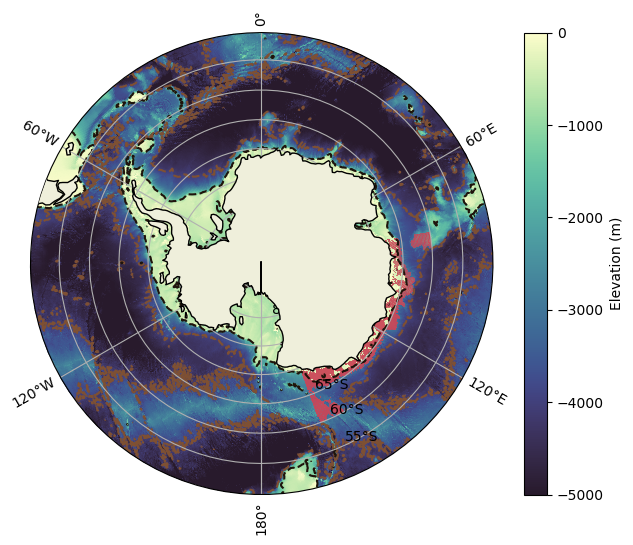

In [70]:
eas = rg('East Antarctic Shelf',[80,160,-85,-60],elevation=gebco_coarse.elevation,max_elevation=-400,min_elevation=-3000)
eas.plot_region()

In [ ]:
f1 = plot_profiles_for_region(most_profiles,markersize=10,markerstyle='x')
most_profiles.plot_region()
f2,ax = timeseries_bar(most_profiles,annual=False)
most_profiles.plot_cmtlgy(sha_gph.gpha)
f4 = climatology_bar(most_profiles)
f=timeseries_with_cmt(most_profiles)